In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    Concatenate, GlobalAveragePooling2D, Resizing,
    RandomFlip, RandomRotation
)
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Cek versi TensorFlow
print("TensorFlow Version:", tf.__version__)

# Konfigurasi GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Menggunakan GPU: {len(gpus)} device(s) ditemukan.")
    except RuntimeError as e:
        print(e)
else:
    print("Tidak ada GPU yang ditemukan, akan menggunakan CPU.")

TensorFlow Version: 2.19.0
Menggunakan GPU: 1 device(s) ditemukan.


In [ ]:
# Konfigurasi Eksperimen
NUM_CLASSES = 10
BATCH_SIZE = 32
EPOCHS = 10

# Ukuran input yang akan diuji
IMG_SIZE_HIGH_RES = (128, 128)
IMG_SIZE_LOW_RES = (64, 64)

# Memuat Dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
INPUT_SHAPE_ORIGINAL = x_train.shape[1:]

# Normalisasi dan One-Hot Encoding
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

print("\nDataset CIFAR-10 siap digunakan.")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

Dataset CIFAR-10 siap digunakan.


In [ ]:
# Definisi arsitektur model
def build_vgg16_sequential(input_shape, num_classes, target_size):
    """Membangun model VGG16 yang disederhanakan dengan Sequential API."""
    model = Sequential([
        Input(shape=input_shape),
        Resizing(target_size[0], target_size[1]),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=f"VGG16_{target_size[0]}x{target_size[1]}")
    return model

def inception_module(x, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    """Helper function untuk Inception module pada GoogLeNet."""
    path1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(f2_in, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(f2_out, (3, 3), padding='same', activation='relu')(path2)
    path3 = Conv2D(f3_in, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(f3_out, (5, 5), padding='same', activation='relu')(path3)
    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(f4_out, (1, 1), padding='same', activation='relu')(path4)
    return Concatenate(axis=-1)([path1, path2, path3, path4])

def build_googlenet_functional(input_shape, num_classes, target_size):
    """Membangun model GoogLeNet yang disederhanakan dengan Functional API."""
    input_layer = Input(shape=input_shape)
    x = Resizing(target_size[0], target_size[1])(input_layer)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer, name=f"GoogLeNet_{target_size[0]}x{target_size[1]}")
    return model

print("\nDefinisi arsitektur model VGG16 dan GoogLeNet siap digunakan.")


Definisi arsitektur model VGG16 dan GoogLeNet siap digunakan.


In [ ]:
 # Fungsi helper untuk eksperimen

def run_experiment(model_builder, model_name_str, scenario_name, target_size, train_data, test_data, use_augmentation=False):
    full_scenario_name = f"{scenario_name} - {model_name_str}"
    print("\n" + "="*70); print(f"MEMULAI: {full_scenario_name}"); print("="*70)

    x_train_local, y_train_local = train_data
    x_test_local, y_test_local = test_data

    data_augmentation = Sequential([Input(shape=INPUT_SHAPE_ORIGINAL), RandomFlip("horizontal"), RandomRotation(0.1)], name='augmentation')
    base_model = model_builder(input_shape=INPUT_SHAPE_ORIGINAL, num_classes=NUM_CLASSES, target_size=target_size)
    model = Sequential([data_augmentation, base_model]) if use_augmentation else base_model

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    start_time = time.time()
    history = model.fit(x_train_local, y_train_local, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test_local, y_test_local), verbose=1)
    runtime = time.time() - start_time
    loss, accuracy = model.evaluate(x_test_local, y_test_local, verbose=0)

    print(f"\nHASIL: Akurasi={accuracy*100:.2f}%, Waktu={runtime:.2f} detik")

    return {'scenario': scenario_name, 'model': model_name_str, 'history': history, 'accuracy': accuracy, 'loss': loss, 'runtime': runtime}

print("\nFungsi helper 'run_experiment' siap digunakan.")


Fungsi helper 'run_experiment' siap digunakan.


In [ ]:
results = []

# 1. Baseline (data lengkap, 128x128) 
results.append(run_experiment(build_vgg16_sequential, "VGG16", "Baseline (128x128)", IMG_SIZE_HIGH_RES, (x_train, y_train_cat), (x_test, y_test_cat)))
results.append(run_experiment(build_googlenet_functional, "GoogLeNet", "Baseline (128x128)", IMG_SIZE_HIGH_RES, (x_train, y_train_cat), (x_test, y_test_cat)))


MEMULAI: Baseline (128x128) - VGG16
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 212s 123ms/step - accuracy: 0.3720 - loss: 1.7120 - val_accuracy: 0.6176 - val_loss: 1.0796
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 177s 113ms/step - accuracy: 0.6326 - loss: 1.0433 - val_accuracy: 0.6704 - val_loss: 0.9336
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 177s 113ms/step - accuracy: 0.7315 - loss: 0.7697 - val_accuracy: 0.7215 - val_loss: 0.8030
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 177s 113ms/step - accuracy: 0.8080 - loss: 0.5600 - val_accuracy: 0.7505 - val_loss: 0.7393
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 177s 113ms/step - accuracy: 0.8805 - loss: 0.3522 - val_accuracy: 0.7461 - val_loss: 0.8648
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 114ms/step - accuracy: 0.9280 - loss: 0.2066 - val_accuracy: 0.7486 - val_loss: 0.9014
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 177s 113ms/step - accuracy: 0.9570 - loss: 0.1272 - val_accuracy: 0.7538 - val_loss: 0.9851
Epoch 8/10
1563/1563 ━━━━

In [ ]:
# 2. Imbalanced data (128x128)
print("\n--- Menyiapkan Data Tidak Seimbang (Imbalanced)... ---")
y_train_labels = np.argmax(y_train_cat, axis=1)
# Kurangi data untuk kelas 0, 1, 2 menjadi setengahnya (2500 sampel)
indices_to_keep = np.concatenate([
    np.where(y_train_labels == i)[0][:2500] if i < 3 else np.where(y_train_labels == i)[0]
    for i in range(NUM_CLASSES)
])
np.random.shuffle(indices_to_keep)
x_train_imb = x_train[indices_to_keep]
y_train_imb = y_train_cat[indices_to_keep]
print(f"Jumlah data training imbalanced: {len(x_train_imb)}")
results.append(run_experiment(build_vgg16_sequential, "VGG16", "Imbalanced Data", IMG_SIZE_HIGH_RES, (x_train_imb, y_train_imb), (x_test, y_test_cat)))
results.append(run_experiment(build_googlenet_functional, "GoogLeNet", "Imbalanced Data", IMG_SIZE_HIGH_RES, (x_train_imb, y_train_imb), (x_test, y_test_cat)))


--- Menyiapkan Data Tidak Seimbang (Imbalanced)... ---
Jumlah data training imbalanced: 42500

MEMULAI: Imbalanced Data - VGG16
Epoch 1/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 167s 121ms/step - accuracy: 0.3776 - loss: 1.7277 - val_accuracy: 0.5709 - val_loss: 1.2099
Epoch 2/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 153s 115ms/step - accuracy: 0.6089 - loss: 1.1111 - val_accuracy: 0.6594 - val_loss: 0.9807
Epoch 3/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 153s 115ms/step - accuracy: 0.7048 - loss: 0.8461 - val_accuracy: 0.6590 - val_loss: 0.9917
Epoch 4/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 152s 115ms/step - accuracy: 0.7804 - loss: 0.6346 - val_accuracy: 0.6989 - val_loss: 0.9027
Epoch 5/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 153s 115ms/step - accuracy: 0.8492 - loss: 0.4325 - val_accuracy: 0.7267 - val_loss: 0.8563
Epoch 6/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 153s 115ms/step - accuracy: 0.9138 - loss: 0.2564 - val_accuracy: 0.7196 - val_loss: 1.0269
Epoch 7/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 153s 115ms/step - accurac

In [ ]:
# 3. Augmented data (Bandingkan data tereduksi dengan dan tanpa augmentasi)
print("\n--- Menyiapkan Data Tereduksi untuk Skenario Augmentasi... ---")
# Ambil 50% data secara acak dari semua kelas
indices_50_percent = np.random.choice(len(x_train), len(x_train) // 2, replace=False)
x_train_red = x_train[indices_50_percent]
y_train_red = y_train_cat[indices_50_percent]
print(f"Jumlah data training tereduksi: {len(x_train_red)}")
# 3a. Reduced data tanpa Augmentasi
results.append(run_experiment(build_vgg16_sequential, "VGG16", "Reduced (No Aug)", IMG_SIZE_HIGH_RES, (x_train_red, y_train_red), (x_test, y_test_cat), use_augmentation=False))
results.append(run_experiment(build_googlenet_functional, "GoogLeNet", "Reduced (No Aug)", IMG_SIZE_HIGH_RES, (x_train_red, y_train_red), (x_test, y_test_cat), use_augmentation=False))
# 3b. Reduced data dengan Augmentasi
results.append(run_experiment(build_vgg16_sequential, "VGG16", "Reduced (With Aug)", IMG_SIZE_HIGH_RES, (x_train_red, y_train_red), (x_test, y_test_cat), use_augmentation=True))
results.append(run_experiment(build_googlenet_functional, "GoogLeNet", "Reduced (With Aug)", IMG_SIZE_HIGH_RES, (x_train_red, y_train_red), (x_test, y_test_cat), use_augmentation=True))


--- Menyiapkan Data Tereduksi untuk Skenario Augmentasi... ---
Jumlah data training tereduksi: 25000

MEMULAI: Reduced (No Aug) - VGG16
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 108s 133ms/step - accuracy: 0.3272 - loss: 1.8476 - val_accuracy: 0.5269 - val_loss: 1.3227
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 120ms/step - accuracy: 0.5525 - loss: 1.2543 - val_accuracy: 0.6081 - val_loss: 1.1141
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 120ms/step - accuracy: 0.6599 - loss: 0.9810 - val_accuracy: 0.6638 - val_loss: 0.9464
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 120ms/step - accuracy: 0.7395 - loss: 0.7401 - val_accuracy: 0.6800 - val_loss: 0.9193
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 120ms/step - accuracy: 0.8088 - loss: 0.5493 - val_accuracy: 0.6844 - val_loss: 0.9878
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 120ms/step - accuracy: 0.8785 - loss: 0.3464 - val_accuracy: 0.7052 - val_loss: 0.9775
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 120ms/step - accuracy: 0.9312 - 

In [ ]:
# 4. Resized input (data lengkap, 64x64) 
results.append(run_experiment(build_vgg16_sequential, "VGG16", "Resized Input (64x64)", IMG_SIZE_LOW_RES, (x_train, y_train_cat), (x_test, y_test_cat)))
results.append(run_experiment(build_googlenet_functional, "GoogLeNet", "Resized Input (64x64)", IMG_SIZE_LOW_RES, (x_train, y_train_cat), (x_test, y_test_cat)))

print("\n" + "#"*70); print("SEMUA EKSPERIMEN TELAH SELESAI"); print("#"*70)


MEMULAI: Resized Input (64x64) - VGG16
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 66s 37ms/step - accuracy: 0.3552 - loss: 1.7386 - val_accuracy: 0.6001 - val_loss: 1.1406
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.6065 - loss: 1.1064 - val_accuracy: 0.6748 - val_loss: 0.9255
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.7065 - loss: 0.8458 - val_accuracy: 0.7349 - val_loss: 0.7670
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.7697 - loss: 0.6674 - val_accuracy: 0.7536 - val_loss: 0.7093
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - accuracy: 0.8208 - loss: 0.5178 - val_accuracy: 0.7662 - val_loss: 0.6822
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 32ms/step - accuracy: 0.8672 - loss: 0.3829 - val_accuracy: 0.7812 - val_loss: 0.6895
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.9082 - loss: 0.2627 - val_accuracy: 0.7855 - val_loss: 0.6931
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━


RINGKASAN AKHIR DAN ANALISIS

--- Tabel Perbandingan Hasil Eksperimen ---
                                accuracy(%) runtime(min)
scenario              model                             
Baseline (128x128)    VGG16           74.51        30.57
                      GoogLeNet       65.30         6.43
Imbalanced Data       VGG16           72.47        25.69
                      GoogLeNet       57.82         5.51
Reduced (No Aug)      VGG16           69.23        15.88
                      GoogLeNet       57.31         3.62
Reduced (With Aug)    VGG16           70.98        17.47
                      GoogLeNet       52.40         3.88
Resized Input (64x64) VGG16           78.30         9.11
                      GoogLeNet       69.35         2.61

--- Grafik 1: Perbandingan Akurasi Validasi per Epoch ---


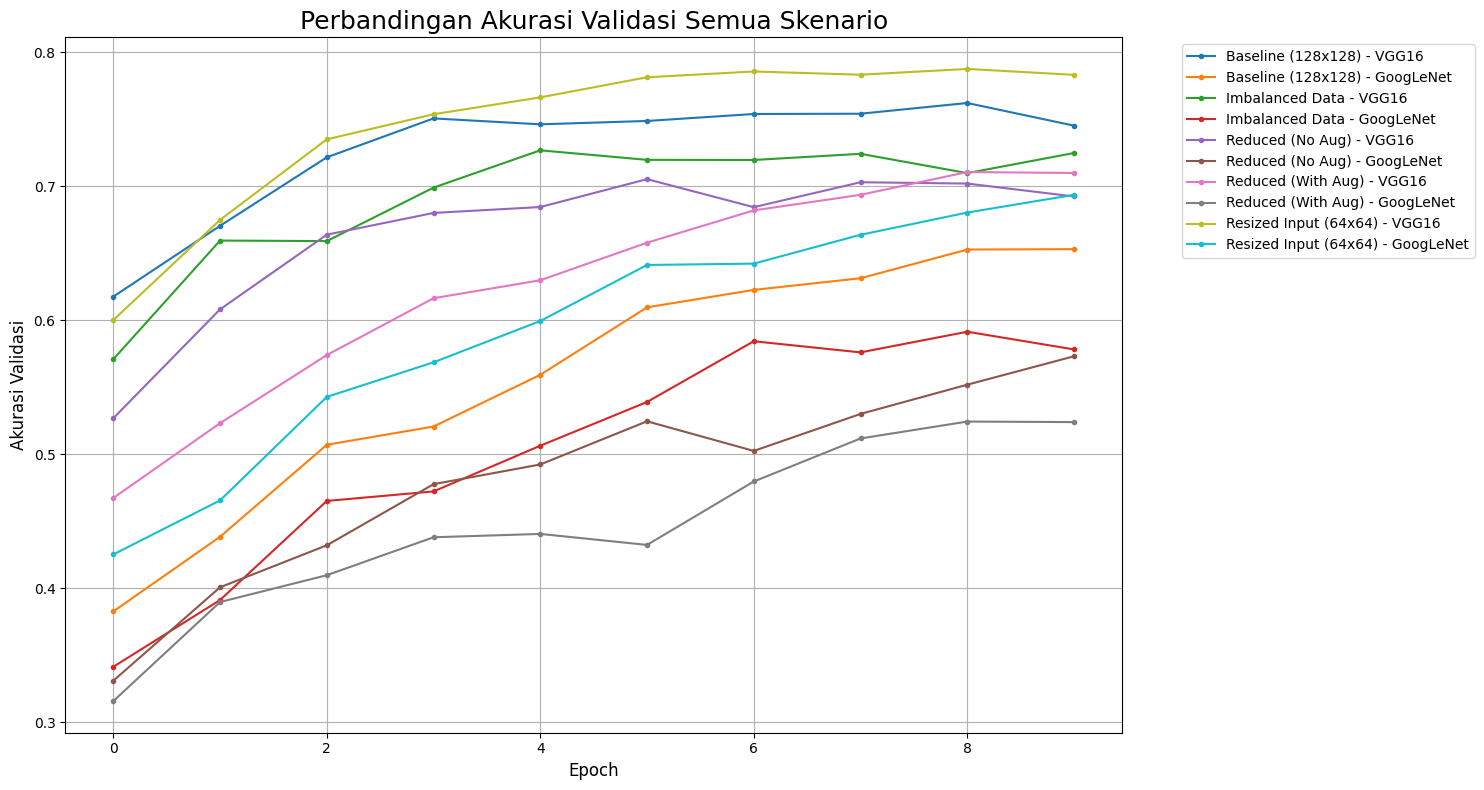


--- Grafik 2: Perbandingan Akurasi Final ---


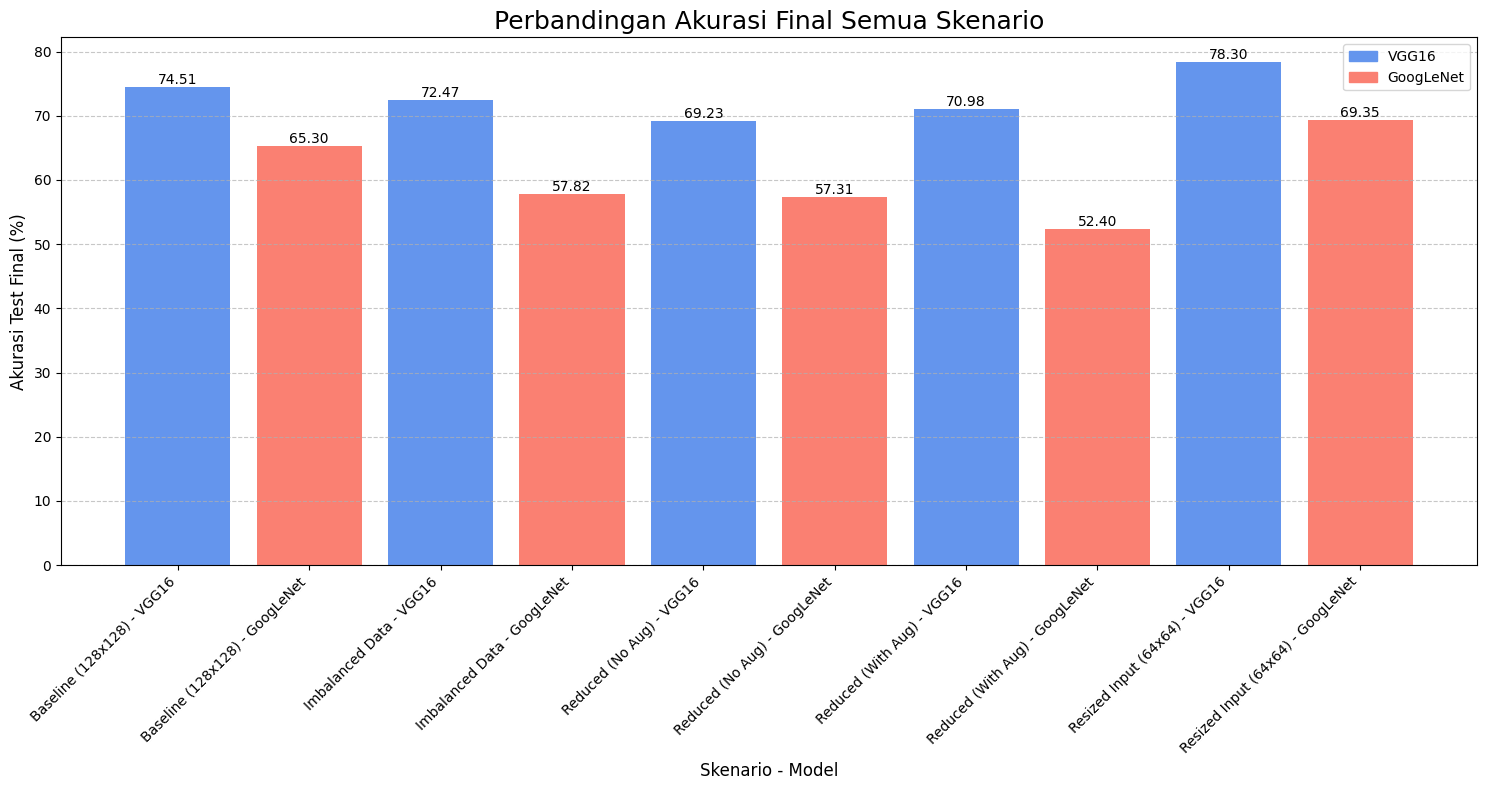


--- Grafik 3: Perbandingan Loss Validasi per Epoch ---


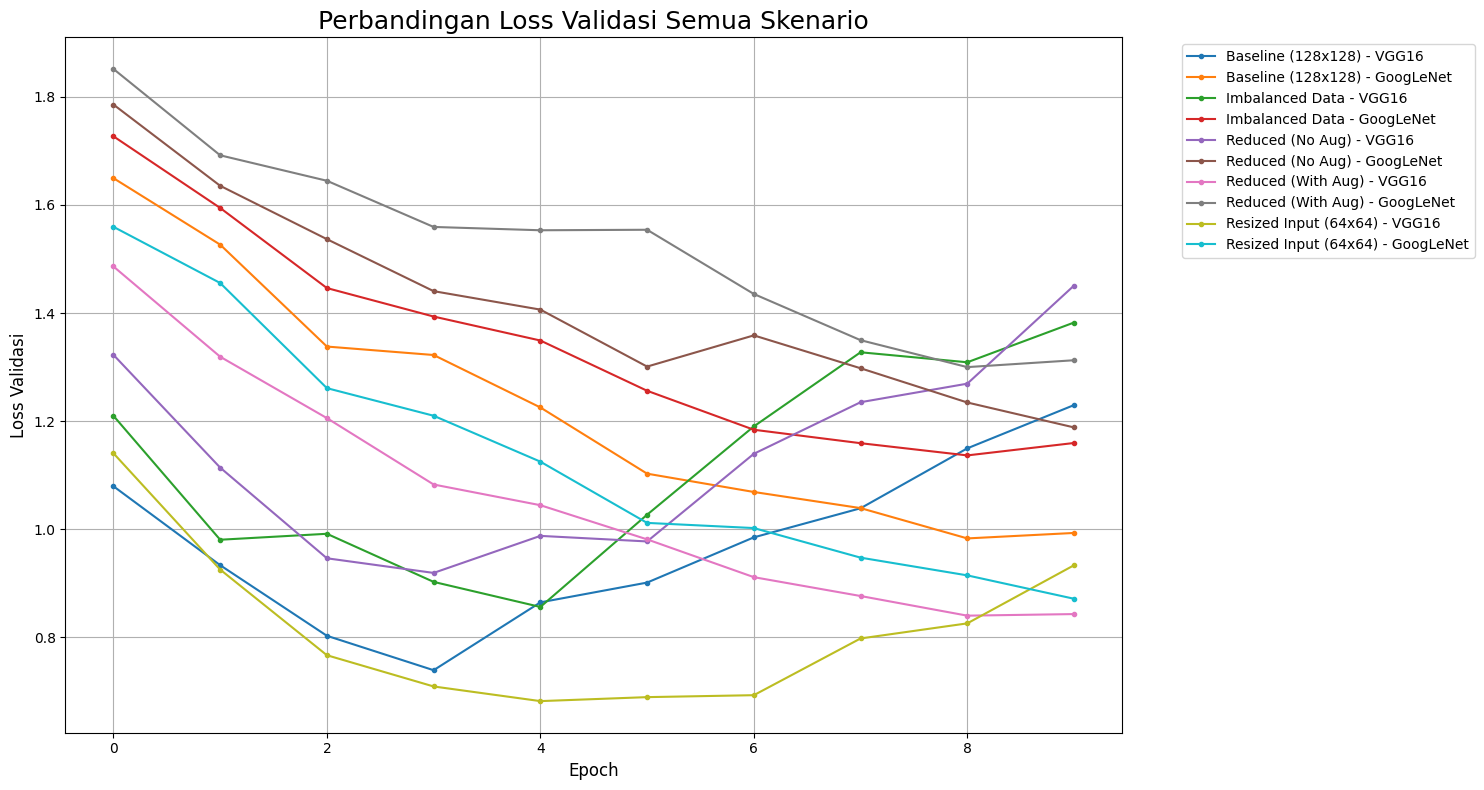


--- Grafik 4: Perbandingan Loss Final ---


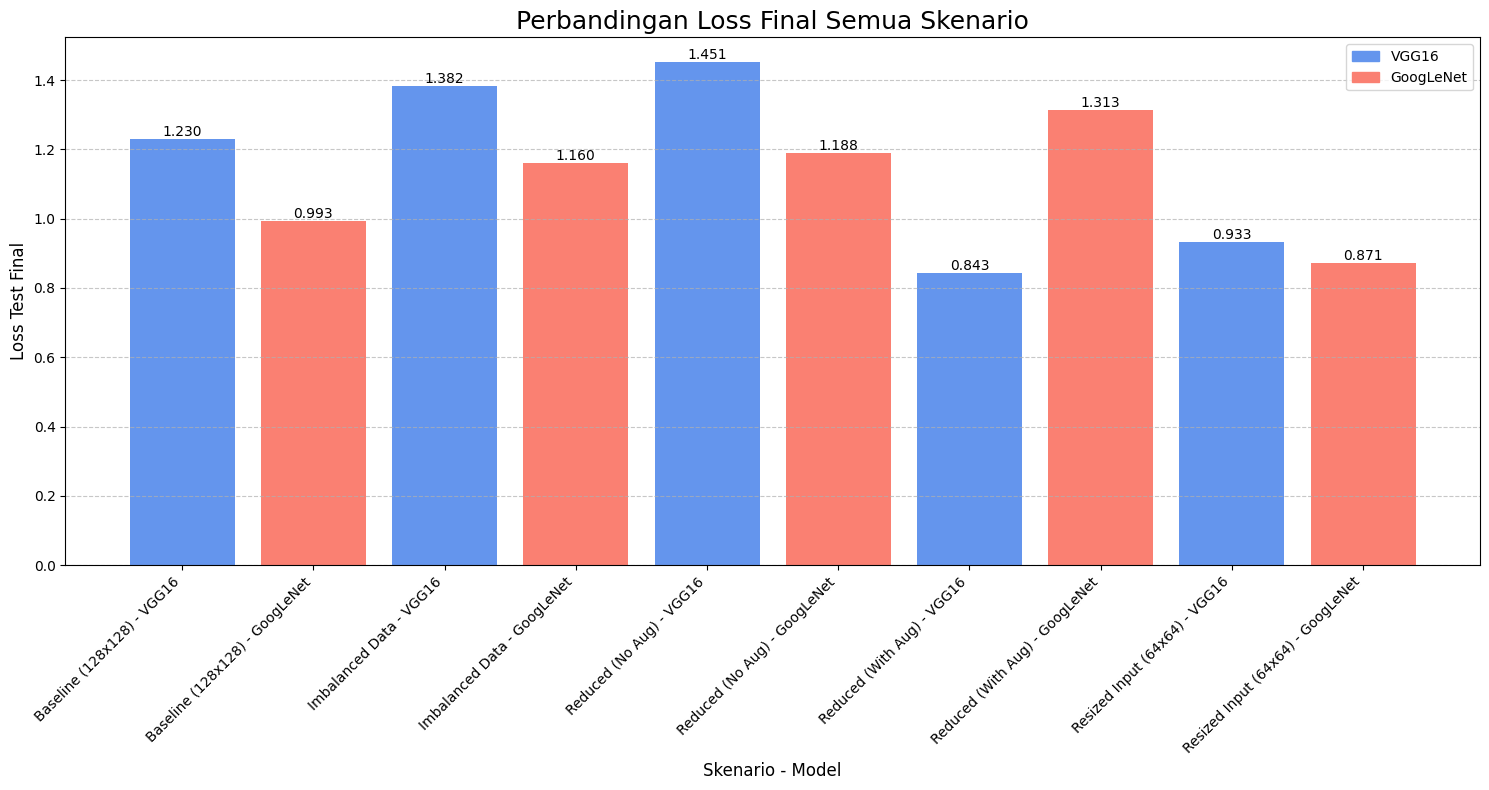

In [ ]:
# Analisis dan visualisasi hasil

import matplotlib.patches as mpatches

if not results:
    print("Tidak ada hasil eksperimen untuk dianalisis.")
else:
    print("\n" + "="*70); print("RINGKASAN AKHIR DAN ANALISIS"); print("="*70)

    # 1. Tabel Hasil
    df_results = pd.DataFrame(results)
    df_display = df_results.copy()
    df_display['runtime(min)'] = df_display['runtime'].apply(lambda x: f"{x/60:.2f}")
    df_display['accuracy(%)'] = df_display['accuracy'].apply(lambda x: f"{x*100:.2f}")
    results_table = df_display[['scenario', 'model', 'accuracy(%)', 'runtime(min)']].set_index(['scenario', 'model'])
    print("\n--- Tabel Perbandingan Hasil Eksperimen ---")
    print(results_table)

    # 2. Membuat 4 Grafik Terpisah

    # Grafik 1: Perbandingan Akurasi Validasi per Epoch pakai line plot
    print("\n--- Grafik 1: Perbandingan Akurasi Validasi per Epoch ---")
    plt.figure(figsize=(15, 8))
    for index, row in df_results.iterrows():
        label = f"{row['scenario']} - {row['model']}"
        plt.plot(row['history'].history['val_accuracy'], label=label, marker='.')
    plt.title('Perbandingan Akurasi Validasi Semua Skenario', fontsize=18)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Akurasi Validasi', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Grafik 2: Perbandingan Akurasi Final pakai bar chart
    print("\n--- Grafik 2: Perbandingan Akurasi Final ---")
    plt.figure(figsize=(15, 8))
    df_results['label'] = df_results['scenario'] + " - " + df_results['model']
    colors = ['cornflowerblue' if model == 'VGG16' else 'salmon' for model in df_results['model']]
    bars = plt.bar(df_results['label'], df_results['accuracy'] * 100, color=colors)
    plt.title('Perbandingan Akurasi Final Semua Skenario', fontsize=18)
    plt.xlabel('Skenario - Model', fontsize=12)
    plt.ylabel('Akurasi Test Final (%)', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.bar_label(bars, fmt='%.2f')
    legend_patches = [mpatches.Patch(color='cornflowerblue', label='VGG16'),
                      mpatches.Patch(color='salmon', label='GoogLeNet')]
    plt.legend(handles=legend_patches)
    plt.tight_layout()
    plt.show()

    # Grafik 3: Perbandingan Loss Validasi per Epoch pakai line plot
    print("\n--- Grafik 3: Perbandingan Loss Validasi per Epoch ---")
    plt.figure(figsize=(15, 8))
    for index, row in df_results.iterrows():
        label = f"{row['scenario']} - {row['model']}"
        plt.plot(row['history'].history['val_loss'], label=label, marker='.')
    plt.title('Perbandingan Loss Validasi Semua Skenario', fontsize=18)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss Validasi', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Grafik 4: Perbandingan Loss Final pakai bar chart
    print("\n--- Grafik 4: Perbandingan Loss Final ---")
    plt.figure(figsize=(15, 8))
    bars = plt.bar(df_results['label'], df_results['loss'], color=colors)
    plt.title('Perbandingan Loss Final Semua Skenario', fontsize=18)
    plt.xlabel('Skenario - Model', fontsize=12)
    plt.ylabel('Loss Test Final', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.bar_label(bars, fmt='%.3f')
    plt.legend(handles=legend_patches)
    plt.tight_layout()
    plt.show()